***Importing Libraries***

The dataset is being imported from torchvision
The images are in the ubyte (unsigned format).

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [2]:
torch.manual_seed(42) # Set seed for reproducibility

Loading the dataset
Testing includes 10,000 images, while training has 50,000 images. The images are 

Before getting the dataset, setting a tranformer to convert the images to tensors and normalizing them, thus making the overall processing much faster

Reference: https://github.com/rasbt/python-machine-learning-book-2nd-edition/issues/68

Reference : https://discuss.pytorch.org/t/loading-mnist-from-pytorch/137456/4

Reference : https://discuss.pytorch.org/t/mnist-normalizing-and-scaling-the-dataset-at-the-same-time/95218

Compose: chains together multiple transformations that will be applied sequentially to the images in the dataset.

.Totensor: This transformation converts the images from PIL format (pixel from 0 to 255) to PyTorch tensors.

Normalize: This transformation normalizes the tensor images to have a mean of 0.5 and a standard deviation of 0.5.

Transformation: pixel values from [0.0, 1.0] to approximately [-1.0, 1.0]

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Understanding the dataset

In [4]:
print("Length of the dataset:", len(train_dataset))
image, label = train_dataset[0]
print('Image shape:', image.shape)
print("Length of the test dataset:", len(test_dataset))
print("Classes in the dataset     :", train_dataset.classes)
print("Classes in the test dataset:", test_dataset.classes)

Length of the dataset: 60000
Image shape: torch.Size([1, 28, 28])
Length of the test dataset: 10000
Classes in the dataset     : ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Classes in the test dataset: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


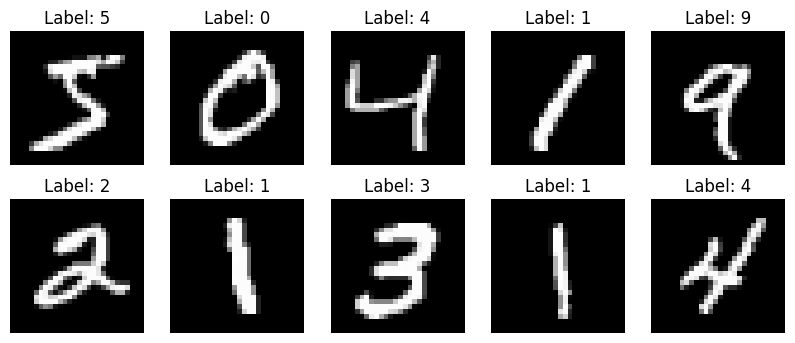

In [5]:
# Visualizing samples
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_dataset[i][0].squeeze(), cmap='gray') #squeeze removes the channel dimension and converts to the type Numpy
    plt.title(f'Label: {train_dataset[i][1]}')
    plt.axis('off')
plt.show()

Using the dataloader

Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [6]:
data_x = train_dataset.data.numpy().reshape(-1, 28 * 28)
data_y = train_dataset.targets.numpy()

In [7]:
print("Shape of the data:", data_x.shape)

Shape of the data: (60000, 784)


Training the NLP Model

#input Layer: 784 neurons (28*28) 
#First Hidden Layer: 30 neurons
#Second hidden Layer: 20 neurons
#Output Layer: 10 neurons

In [8]:
# Activation functions
#for activation between neurons : ReLU
# Options are ReLU, Sigmoid, and Tanh
def relu(x):
    return torch.max(torch.tensor(0), x)
#for activation at the output layer
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

Writing the class for the main model

In [9]:
class mnsit_pred(nn.Module): #we are deriving from nn.Module as the base class
    #creating a constructor
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, activation_fn=nn.ReLU):
        super(mnsit_pred, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) 
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.activation = activation_fn() #activation function which we can pass as a parameter

    #defining a forward function
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

Writing a function for cross entropy loss and optimizer

Inside the loss function calculation, we have taken some addition to the y_pred, to have numerical stability. For now, various websites have mentioned to take it as 1e-10.

In [10]:
def cross_entropy_loss(y_pred, y_true):
    #to get the probabilities
    y_pred = torch.softmax(y_pred, dim=1)
    #loss for multi-class classification
    return -torch.sum(y_true * torch.log(y_pred + 1e-10))/y_pred.size(0) 

def optimizer_select(model, optimizer_input, learning_rate):
    if optimizer_input == 'SGD':
        return torch.optim.SGD(model.parameters(), lr=learning_rate)
    else:
        return torch.optim.Adam(model.parameters(), lr=learning_rate)


Setting hyperparameters

In [11]:
#taking the batch size to be 128
batch_size = 128 #although this is not being used
epochs = 10000
learning_rate = 0.001
hidden_size1 = 30
hidden_size2 = 20
num_classes = 10
input_size = 28 * 28

Need to one hot encode the labels

In [12]:
data_y_one_hot = np.zeros((data_y.size, num_classes))

for a in range(len(data_y)):
    data_y_one_hot[a][data_y[a]] = 1


#obtaining the tensor values
data_x_tensor = torch.tensor(data_x, dtype=torch.float)
data_y_tensor = torch.tensor(data_y_one_hot, dtype=torch.float)


Training the Main model

In [13]:
model = mnsit_pred(input_size, hidden_size1, hidden_size2, num_classes)
optimizer = optimizer_select(model, 'adam', learning_rate)

In [14]:
epoch_val = []
loss_val = []

In [15]:
epoch = 0
while epoch<epochs: #setting arb limit
    model.train()
    optimizer.zero_grad()
    output = model(data_x_tensor)
    loss = cross_entropy_loss(output, data_y_tensor)
    loss.backward()
    optimizer.step()

    if(epoch % 50 == 0):
        print(f'Epoch {epoch}, Loss: {loss}')
        epoch_val.append(epoch)
        loss_val.append(loss)
    epoch += 1

Epoch 0, Loss: 10.69740104675293
Epoch 50, Loss: 0.5514833927154541
Epoch 100, Loss: 0.3353956341743469
Epoch 150, Loss: 0.25674593448638916
Epoch 200, Loss: 0.21432960033416748
Epoch 250, Loss: 0.1841665804386139
Epoch 300, Loss: 0.16212695837020874
Epoch 350, Loss: 0.14539222419261932
Epoch 400, Loss: 0.13204710185527802
Epoch 450, Loss: 0.12111322581768036
Epoch 500, Loss: 0.11211210489273071
Epoch 550, Loss: 0.1042971983551979
Epoch 600, Loss: 0.0971834734082222
Epoch 650, Loss: 0.09091300517320633
Epoch 700, Loss: 0.085328109562397
Epoch 750, Loss: 0.08010978251695633
Epoch 800, Loss: 0.07540012896060944
Epoch 850, Loss: 0.071061871945858
Epoch 900, Loss: 0.06687165051698685
Epoch 950, Loss: 0.06309199333190918
Epoch 1000, Loss: 0.05954733118414879
Epoch 1050, Loss: 0.05613180994987488
Epoch 1100, Loss: 0.05284509435296059
Epoch 1150, Loss: 0.049879949539899826
Epoch 1200, Loss: 0.047205355018377304
Epoch 1250, Loss: 0.04452066123485565
Epoch 1300, Loss: 0.04224755987524986
Epoch 

Plotting the graph

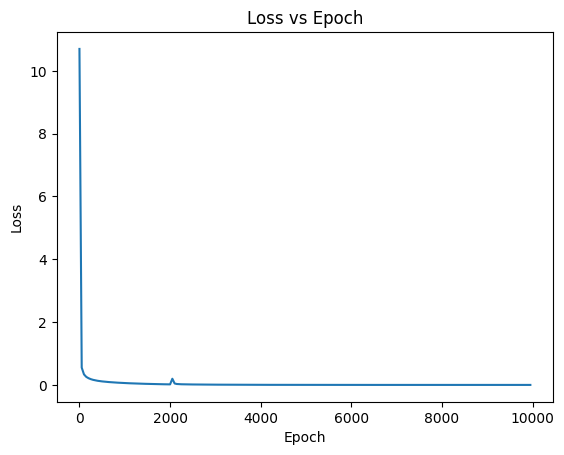

In [16]:
loss_list_converted = [i.detach().numpy() for i in loss_val]
#plotting the plot of loss vs epoch
plt.plot(epoch_val, loss_list_converted)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

Testing the model on the testing dataset

In [17]:
model.eval() #so that there are no changes in the parameters of the model

data_x_test= test_dataset.data.numpy().reshape(-1, 28 * 28)
data_y_test = test_dataset.targets.numpy()

#converting the data to tensor
data_x_test_tensor = torch.tensor(data_x_test, dtype=torch.float)
data_y_test_tensor = torch.tensor(data_y_test, dtype=torch.long) #this has to be long


In [18]:
predicted_label = []
actual_label_test = []

with torch.no_grad():
    output = model(data_x_test_tensor)
    predicted = output.argmax(dim=1)

#need to take the float value to feed in the confusion matrix
for a in predicted:
    predicted_label.append(float(a))

#same for the label values present in data_y_test_tensor

for a in data_y_test_tensor:
    actual_label_test.append(float(a))

Creating Confusion matrix for NN trained Model

In [19]:
f1_nn = f1_score(actual_label_test, predicted, average='weighted')
conf_matrix_nn = confusion_matrix(actual_label_test, predicted)

print("F1 score:", f1_nn)

F1 score: 0.938936431577773


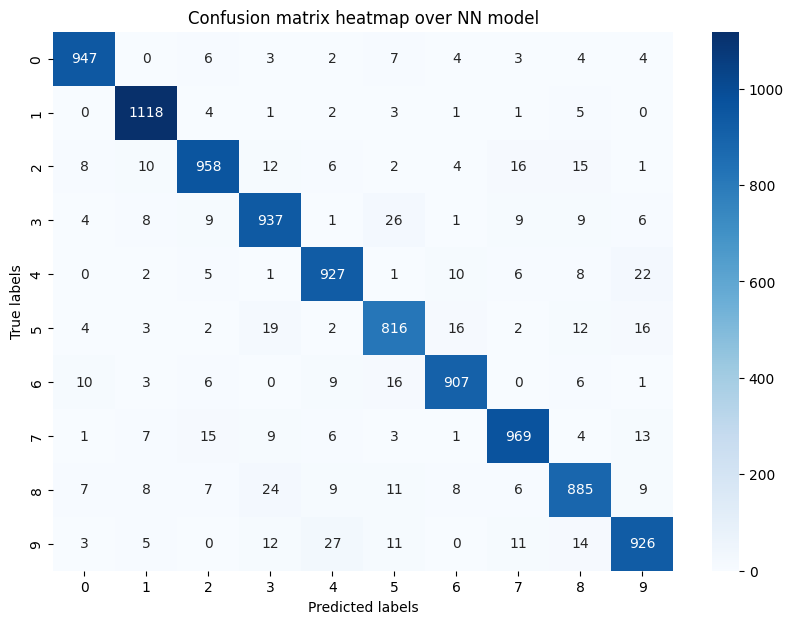

In [20]:
labels = []
for a in range(0, 10):
    labels.append(a)
plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix heatmap over NN model')
plt.show()


In [21]:
digit_confusion = {}
for i in range(10):
    digit_confusion[i] = conf_matrix_nn[i]

#list to store the top confusion values
nn_confusion = []


#taking top k values
k = 2

for digits, count in digit_confusion.items():
    #creating a list to store the confused digits and their counts
    confused_digits = []

    for j in range(10):
        if j != digits and count[j] > 0:
            confused_digits.append((j, count[j]))

    #sorting the confused digits by count in descending order
    confused_digits.sort(key=lambda x: x[1], reverse=True)

    top_confused_values = []

    #taking the to k values
    for i in range(min(k, len(confused_digits))):
        top_confused_values.append(confused_digits[i][0])
    
    print(f"Digit {digits} confused with: {top_confused_values}")
    nn_confusion.append(top_confused_values)

Digit 0 confused with: [5, 2]
Digit 1 confused with: [8, 2]
Digit 2 confused with: [7, 8]
Digit 3 confused with: [5, 2]
Digit 4 confused with: [9, 6]
Digit 5 confused with: [3, 6]
Digit 6 confused with: [5, 0]
Digit 7 confused with: [2, 9]
Digit 8 confused with: [3, 5]
Digit 9 confused with: [4, 8]


Comparison with Other Models such as Random Forest and Logistic Regression Model

Training a Random Forest Model

In [22]:
#converting the data to numpy array
data_y_labels_rf = np.argmax(data_y_one_hot, axis=1)

#training the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) #100 trees being trained in the forest

#fitting the data on the model
rf_model.fit(data_x, data_y_labels_rf)

RandomForestClassifier(random_state=42)

Testing the datsaet on the Random Forest Model

In [23]:
test_predictions = rf_model.predict(data_x_test)

Creating Confusion matrix for Random Forest Model

In [24]:

f1_RF = f1_score(data_y_test, test_predictions, average='weighted')
conf_matrix_rf = confusion_matrix(data_y_test, test_predictions)

print("F1 score:", f1_RF)

F1 score: 0.9690853936213123


Plotting a heat map of the predictions

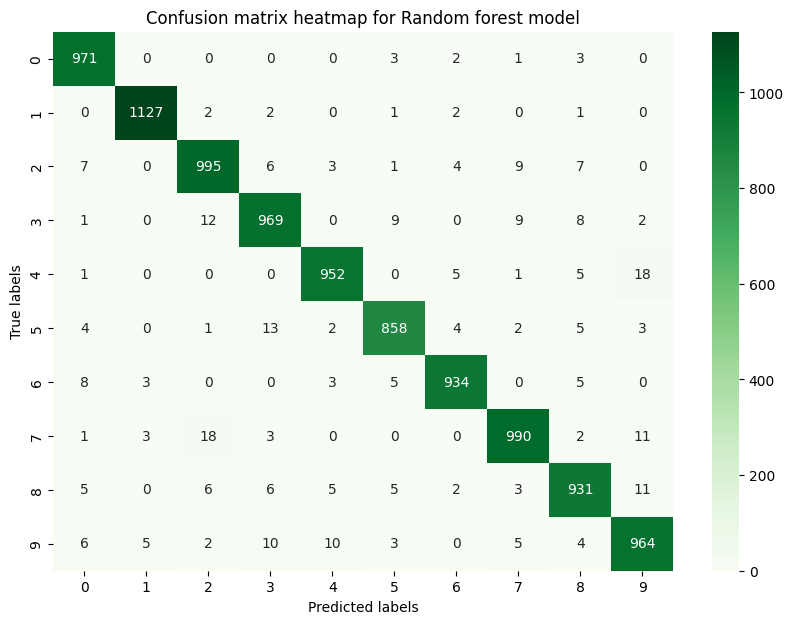

In [25]:
labels = []
for a in range(0, 10):
    labels.append(a)
plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix heatmap for Random forest model')
plt.show()

Finding the most common confusions for each digit

In [26]:
digit_confusion = {}
for i in range(10):
    digit_confusion[i] = conf_matrix_rf[i]

#for dataframing for comparision
rf_confusions = []


for digits, count in digit_confusion.items():
    #creating a list to store the confused digits and their counts
    confused_digits = []

    for j in range(10):
        if j != digits and count[j] > 0:
            confused_digits.append((j, count[j]))

    #sorting the confused digits by count in descending order
    confused_digits.sort(key=lambda x: x[1], reverse=True)

    top_confused_values = []

    #taking the to k values
    for i in range(min(k, len(confused_digits))):
        top_confused_values.append(confused_digits[i][0])
    
    print(f"Digit {digits} confused with: {top_confused_values}")
    rf_confusions.append(top_confused_values)

Digit 0 confused with: [5, 8]
Digit 1 confused with: [2, 3]
Digit 2 confused with: [7, 0]
Digit 3 confused with: [2, 5]
Digit 4 confused with: [9, 6]
Digit 5 confused with: [3, 8]
Digit 6 confused with: [0, 5]
Digit 7 confused with: [2, 9]
Digit 8 confused with: [9, 2]
Digit 9 confused with: [3, 4]


Training a model using Logistic Regression

In [27]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(data_x, data_y_labels_rf)  # Reusing the same data

/Users/tejasmacipad/Desktop/Second_yr/Machine_Learning/es335-24-fall-assignment-3/venv_es335_3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=10000)

In [28]:
# Make predictions on the test set
predicted = log_reg.predict(data_x_test)

Comparing the performance of the models using the confusion matrix and the F1 score

In [29]:
f1_lr = f1_score(data_y_test, predicted, average='weighted')
conf_matrix_lr = confusion_matrix(data_y_test, predicted)

In [30]:
print("F1 score:", f1_lr)

F1 score: 0.9200262758908031


Plotting the confusion matrix for the Logistic Regression Model

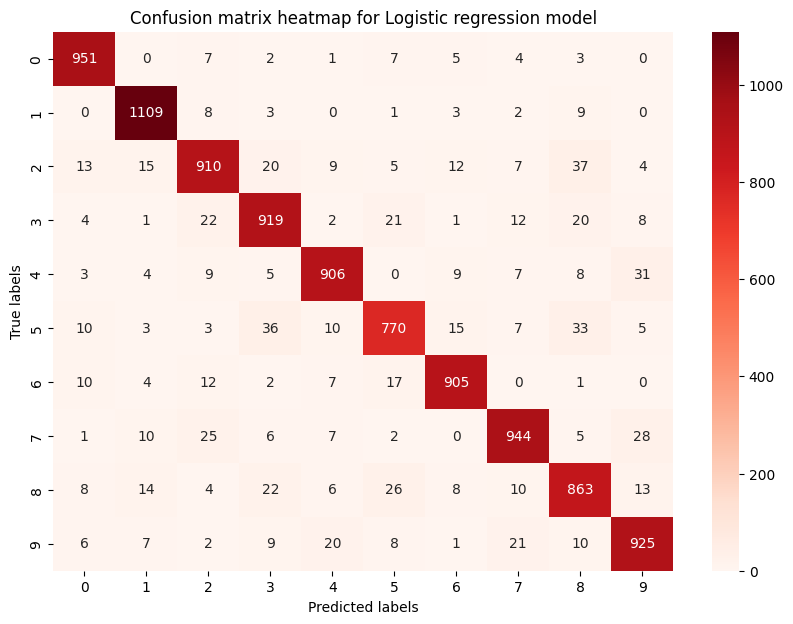

In [31]:
labels = []
for a in range(0, 10):
    labels.append(a)
plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix heatmap for Logistic regression model')
plt.show()


126 vertic
111 horiz

In [32]:
digit_confusion = {}
for i in range(10):
    digit_confusion[i] = conf_matrix_lr[i]

#list to store the top confusion values
lr_confusion = []


for digits, count in digit_confusion.items():
    #creating a list to store the confused digits and their counts
    confused_digits = []

    for j in range(10):
        if j != digits and count[j] > 0:
            confused_digits.append((j, count[j]))

    #sorting the confused digits by count in descending order
    confused_digits.sort(key=lambda x: x[1], reverse=True)

    top_confused_values = []

    #taking the to k values
    for i in range(min(k, len(confused_digits))):
        top_confused_values.append(confused_digits[i][0])
    
    print(f"Digit {digits} confused with: {top_confused_values}")
    lr_confusion.append(top_confused_values)

Digit 0 confused with: [2, 5]
Digit 1 confused with: [8, 2]
Digit 2 confused with: [8, 3]
Digit 3 confused with: [2, 5]
Digit 4 confused with: [9, 2]
Digit 5 confused with: [3, 8]
Digit 6 confused with: [5, 2]
Digit 7 confused with: [9, 2]
Digit 8 confused with: [5, 3]
Digit 9 confused with: [7, 4]


 Comparing performance of the models using the F1 score and the correct predictions

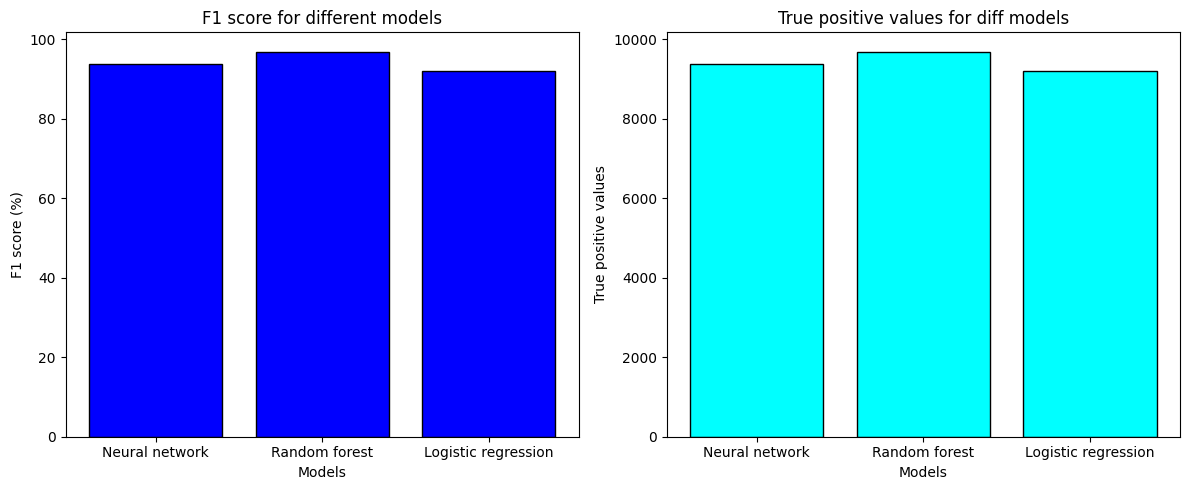

In [33]:
TP_nn = np.diag(conf_matrix_nn)  # True Positives for Neural Network
TP_rf = np.diag(conf_matrix_rf)  # True Positives for Random Forest
TP_lr = np.diag(conf_matrix_lr)  # True Positives for Logistic Regression

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x_axis = ['Neural network', 'Random forest', 'Logistic regression']
y_axis = [f1_nn * 100, f1_RF * 100, f1_lr * 100]

axes[0].bar(x_axis, y_axis, color='blue', edgecolor='black')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('F1 score (%)')
axes[0].set_title('F1 score for different models')

y_axis_tp = [sum(TP_nn), sum(TP_rf), sum(TP_lr)]
axes[1].bar(x_axis, y_axis_tp, color='cyan', edgecolor='black')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('True positive values')
axes[1].set_title('True positive values for diff models')

plt.tight_layout()
plt.show()

Forming a dataframe to display the top k most common confusions for each digit

In [34]:
nn_confusion
lr_confusion
rf_confusions

#these three store the highest k confused values for the respective models
#here we will form a dataframe such that, first column contains the digit, next k columns the next k confused values for nn, then next k for confused values for rf and then for lr

num_digits = 10
k = len(nn_confusion[0])  # Number of confused values

data = np.zeros((num_digits, 1 + 3 * k))
data[:, 0] = np.arange(num_digits)

data[:, 1:k + 1] = nn_confusion 
data[:, k + 1:2 * k + 1] = rf_confusions
data[:, 2 * k + 1:] = lr_confusion

#naming the column
column_names = ['Digit']
for i in range(1, k + 1):
    column_names.append(f'NN_most_confused_{i}')
for i in range(1, k + 1):
    column_names.append(f'RF_most_confused_{i}')
for i in range(1, k + 1):
    column_names.append(f'LR_most_confused_{i}')

confusion_df = pd.DataFrame(data, columns=column_names)

print(confusion_df)


   Digit  NN_most_confused_1  NN_most_confused_2  RF_most_confused_1  \
0    0.0                 5.0                 2.0                 5.0   
1    1.0                 8.0                 2.0                 2.0   
2    2.0                 7.0                 8.0                 7.0   
3    3.0                 5.0                 2.0                 2.0   
4    4.0                 9.0                 6.0                 9.0   
5    5.0                 3.0                 6.0                 3.0   
6    6.0                 5.0                 0.0                 0.0   
7    7.0                 2.0                 9.0                 2.0   
8    8.0                 3.0                 5.0                 9.0   
9    9.0                 4.0                 8.0                 3.0   

   RF_most_confused_2  LR_most_confused_1  LR_most_confused_2  
0                 8.0                 2.0                 5.0  
1                 3.0                 8.0                 2.0  
2              

**Observations**

Accuracy: 

The random forest has the highest F1 score, followed by the neural network and the logistic regression model.


The random forests also took least amount of training time, as well as less number of epochs. The reason, that despite NN having much more better potential to capture the non-linearities, it might require more fine hypertuning.

Also there is high similarity, in the behavior of prediction by all the three models, while they also show similarity in the confusion matrix, for getting confused for some digits such as 2, 5, 8, 0.

For all the models, digits such as 5, which share similarity in shape with various other digits, such as 3, 8, 6, 0, 2, are the most confused digits, and have significantly less accuracy.


As we can see in the dataframe plotted above, if we take the case of the number 0, we can see that the most confused digit for all the three models is either 2 or 5.

Part - 2

Plotting the t-SNE for the output from the layer containing 20 neurons for the 10 digits.

Explanation:

t-SNE is a method based on the stochastic neighbor embedding, which is used to visualize high-dimensional data by giving each datapoint a location in a two or three-dimensional map.

In the first step, for each of the point, similarity is calculated between all the points, which is based on the gaussian distribution. In this, the point of concern is placed at the mean, and then all the points are placed on the number line at a distance, which is in higher dimension (euclidean distance), and then the y coordinate can be calculated on the gaussian distribution. Normalized at the end. We obtain (N x N) matrix, where N is the number of points.

This is repeated for all the points.

THen the points are randomly placed on the lower dimension space, and the same step is repeated, but this time we use t distribution, and again for N points, we obtain a matrix of size NxN, which contains the distance based similarity for the points placed randomly on the lower dimension.

The task performed is then such that, to make these two graphs as much similar as possible.

In reference to the second layer of neural network, we have 20 neurons, and we are plotting the t-SNE for the output of these 20 neurons, for the 10 digits.
So, for each of the input image, we are getting an output vector of length 20. This data is in the form of 20 dimensions, and in order to visualize, that is t check whether actaully the prediction of the numbers is happenning, we need to reduce the dimensionality of the data, and then plot it.

In this, similar digits, will tend to get clustered together, and we can see the similarity in the digits, and how the model is able to differentiate between the digits, as those numbers which are quite different, will be separated by a large distance.

In [35]:
#obtaining the tSNE plot for the testing dataset.add
#passing this data into the neural network, and getting the output 

with torch.no_grad():
    layer_1_ouput = model.activation(model.fc1(data_x_test_tensor))
    layer_2_output = model.activation(model.fc2(layer_1_ouput))


tsne_2d = TSNE(n_components=2, random_state=42)
tsne_3d = TSNE(n_components=3, random_state=42)
layer_2_output = layer_2_output.numpy()

layer_2_output_2d = tsne_2d.fit_transform(layer_2_output)
layer_2_output_3d = tsne_3d.fit_transform(layer_2_output)

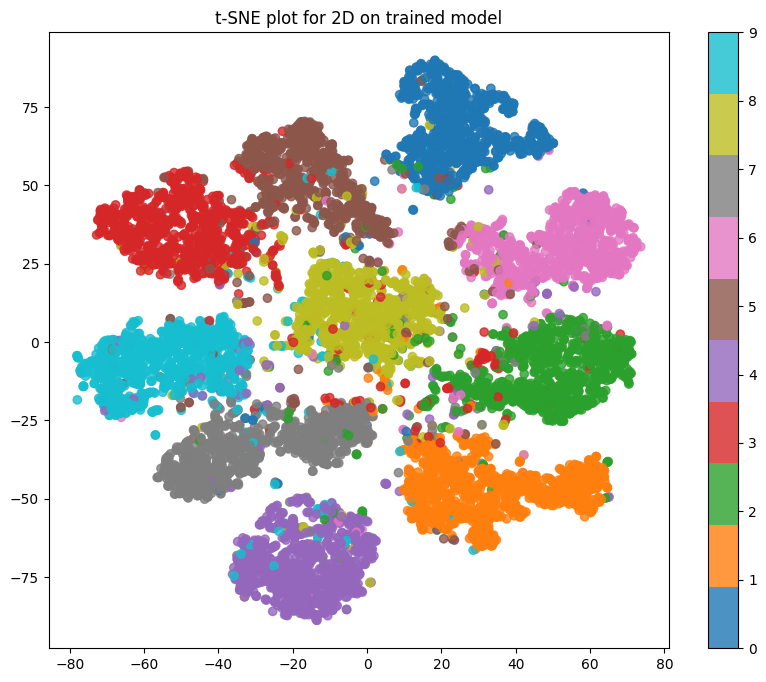

In [36]:
#plotting the 2d tSNE plot
# print(layer_2_output_2d.shape)

#for assignning the colors, we can use the feature of the parameter c, which assigns different colors to the points, according to their values present in the data_y_test

plt.figure(figsize=(10, 8))
plt.scatter(layer_2_output_2d[:, 0], layer_2_output_2d[:, 1], c=data_y_test, cmap='tab10', alpha=0.8)
plt.colorbar()
plt.title('t-SNE plot for 2D on trained model')
plt.show()

Plotting 3d tSNE graph of the same

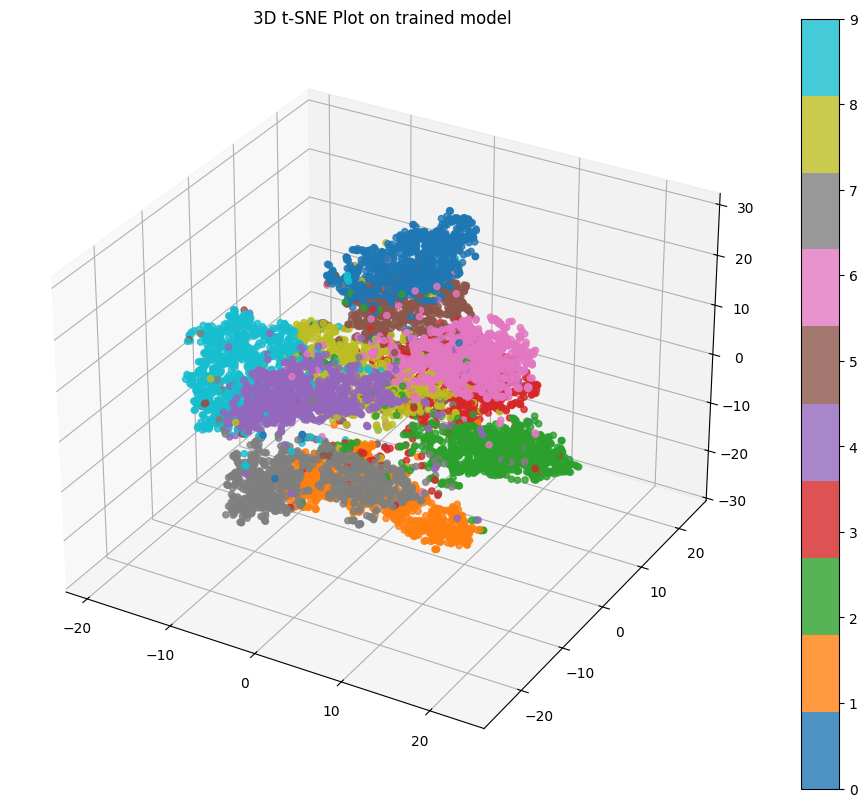

In [37]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotting with 'plasma' colormap for better colors
scatter = ax.scatter(
    layer_2_output_3d[:, 0], 
    layer_2_output_3d[:, 1], 
    layer_2_output_3d[:, 2], 
    c=data_y_test, cmap='tab10', alpha=0.8
)

# Simplified colorbar
colorbar = plt.colorbar(scatter)
plt.title('3D t-SNE Plot on trained model')
plt.show()

Now plotting from untrained model

In [38]:
model_untrained = mnsit_pred(input_size, hidden_size1, hidden_size2, num_classes)

with torch.no_grad():
    layer_1_output_untrained = model_untrained.activation(model_untrained.fc1(data_x_test_tensor))
    layer_2_output_untrained = model_untrained.activation(model_untrained.fc2(layer_1_output_untrained))

layer_2_output_untrained = layer_2_output_untrained.numpy()

layer_2_output_2d = tsne_2d.fit_transform(layer_2_output_untrained)
layer_2_output_3d = tsne_3d.fit_transform(layer_2_output_untrained)

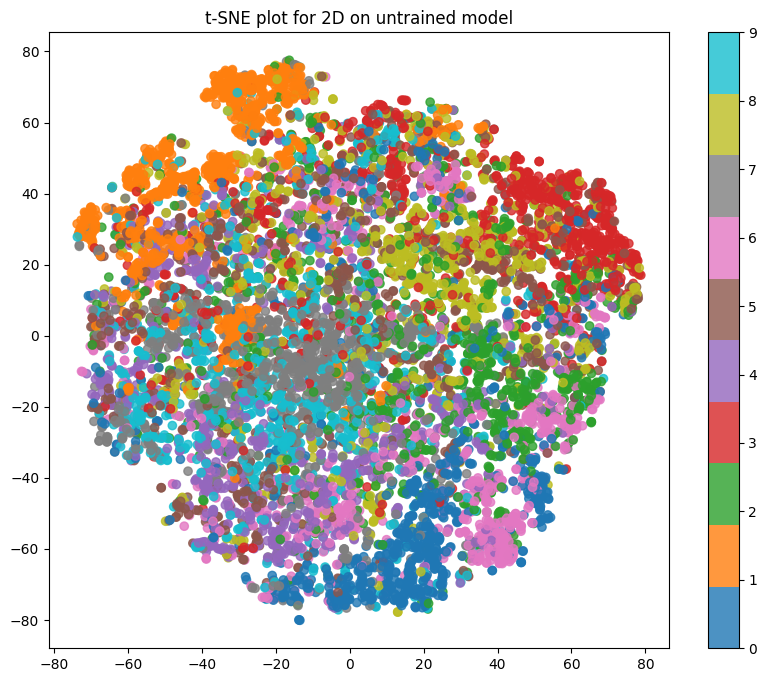

In [39]:
#plotting the 2d tSNE plot
# print(layer_2_output_2d.shape)

#for assignning the colors, we can use the feature of the parameter c, which assigns different colors to the points, according to their values present in the data_y_test

plt.figure(figsize=(10, 8))
plt.scatter(layer_2_output_2d[:, 0], layer_2_output_2d[:, 1], c=data_y_test, cmap='tab10', alpha=0.8)
plt.colorbar()
plt.title('t-SNE plot for 2D on untrained model')
plt.show()

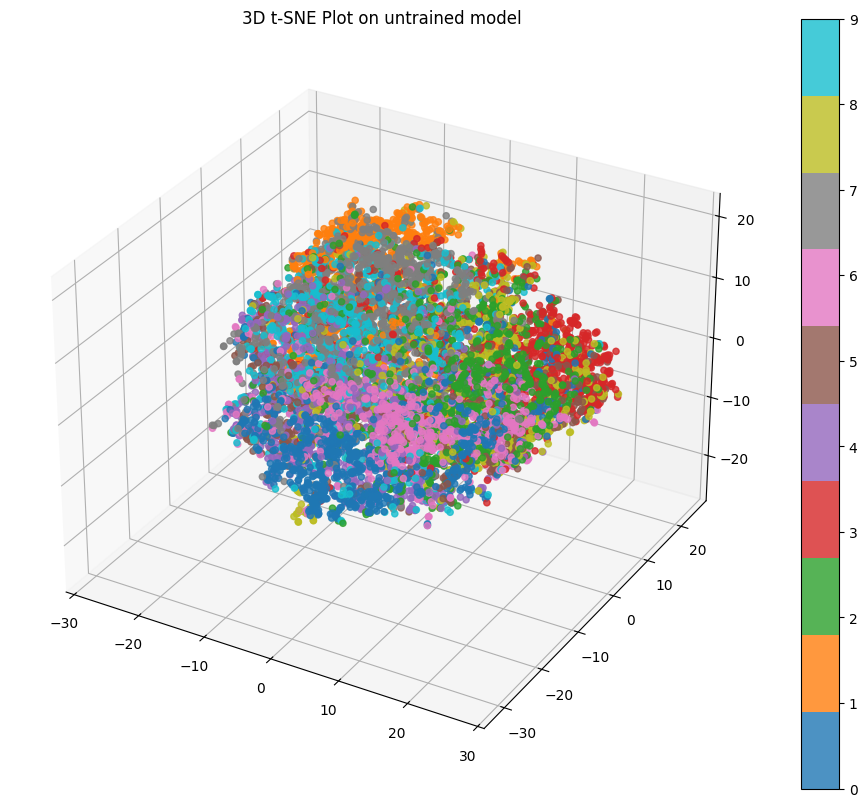

In [40]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotting with 'plasma' colormap for better colors
scatter = ax.scatter(
    layer_2_output_3d[:, 0], 
    layer_2_output_3d[:, 1], 
    layer_2_output_3d[:, 2], 
    c=data_y_test, cmap='tab10', alpha=0.8
)

# Simplified colorbar
colorbar = plt.colorbar(scatter)
plt.title('3D t-SNE Plot on untrained model')
plt.show()

Conclusion

From the graph it is visible that, as explained earlier, upon training the second hidden layer starts classifying the digits, and we can see that the digits are getting clustered together, and the model is able to differentiate between the digits. Upon running the tSNE upon the obtained vector, they were almost perfectly clustered, as well as similar digits were placed close to each other.

Observing the untrained model, it is visible that the digits are not getting clustered, and are placed randomly, which shows that the model is not able to differentiate between the digits, and the model is not able to classify the digits.

Part - 3

Acquiring the Data

In [41]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset_fashion = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_fashion = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [42]:
print("Length of the dataset:", len(train_dataset_fashion))
image, label = train_dataset_fashion[0]
print('Image shape:', image.shape)
print("Length of the test dataset:", len(test_dataset_fashion))
print("Classes in the dataset     :", train_dataset_fashion.classes)
print("Classes in the test dataset:", test_dataset_fashion.classes)

Length of the dataset: 60000
Image shape: torch.Size([1, 28, 28])
Length of the test dataset: 10000
Classes in the dataset     : ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Classes in the test dataset: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


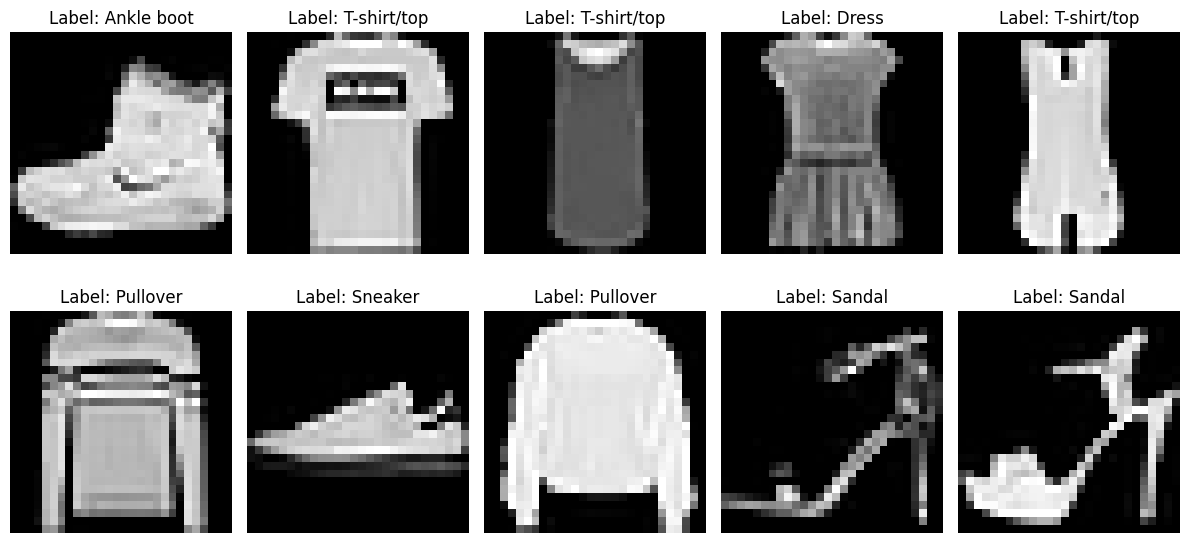

In [43]:
#names of the classes

class_names = train_dataset_fashion.classes
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    image, label = train_dataset_fashion[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Label: {class_names[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Training the model over fashion MNIST dataset

In [44]:
#as done earlier, converting the data to numpy array
train_images = train_dataset_fashion.data.numpy().reshape(-1, 28 * 28)
train_labels = train_dataset_fashion.targets.numpy()
test_images = test_dataset_fashion.data.numpy().reshape(-1, 28 * 28)
test_labels = test_dataset_fashion.targets.numpy()

In [45]:
print("Shape of the data:", train_images.shape)

Shape of the data: (60000, 784)


In [46]:
#we need them as tensors for testing
train_images_tensor = torch.tensor(train_images, dtype=torch.float)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_images_tensor = torch.tensor(test_images, dtype=torch.float)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

In [47]:
model.eval()

with torch.no_grad():
    output = model(train_images_tensor)
predicted = output.argmax(dim=1)
correct = (predicted == train_labels).sum().item()
accuracy = correct * 100 / len(train_labels)

In [48]:
print(accuracy)


predicted = predicted.numpy()

#creating confusion matrix
conf_matrix = confusion_matrix(train_labels, predicted)


3.215


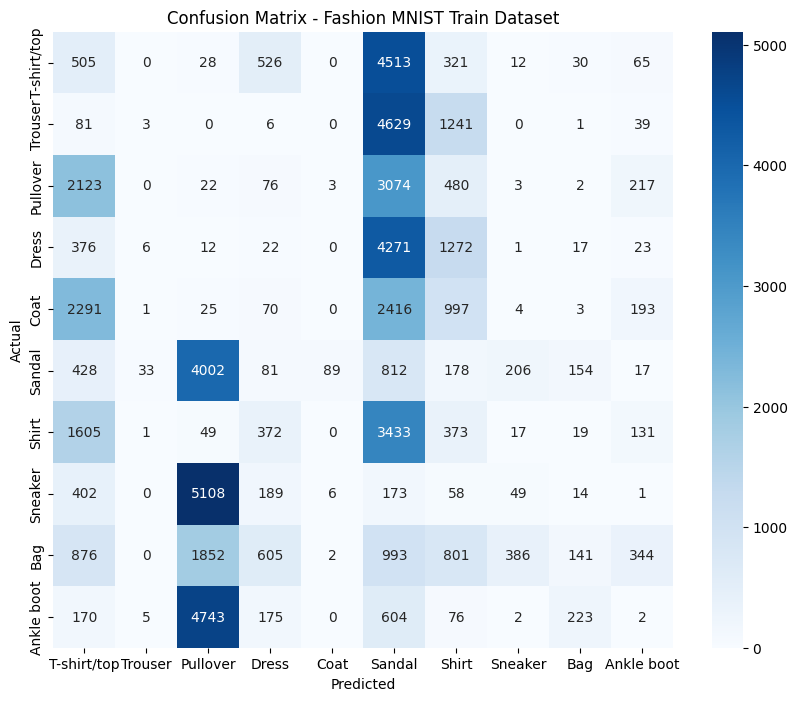

In [49]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=train_dataset_fashion.classes, 
            yticklabels=train_dataset_fashion.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Fashion MNIST Train Dataset')
plt.show()

Testing the trained model on numbers dataset to test for the fashion dataset test dataset

In [50]:
model.eval()

with torch.no_grad():
    output = model(test_images_tensor)
predicted = output.argmax(dim=1)
correct = (predicted == test_labels).sum().item()
accuracy = correct * 100 / len(test_labels)

In [51]:
print(accuracy)


predicted = predicted.numpy()

#creating confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted)


3.54


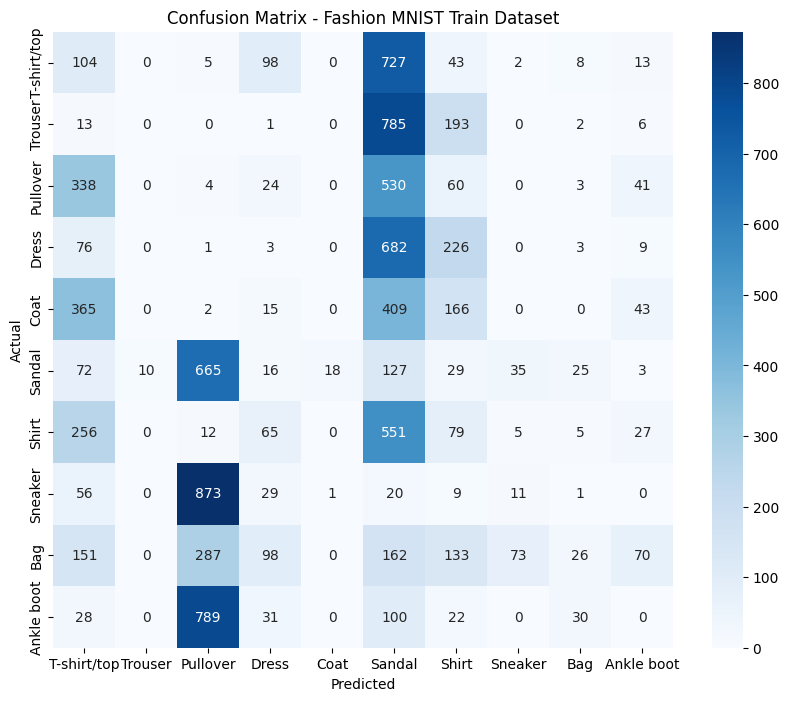

In [52]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=train_dataset_fashion.classes, 
            yticklabels=train_dataset_fashion.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Fashion MNIST Train Dataset')
plt.show()

Observations

As expected the accuracy is quite low, as the model was trained on the numbers dataset, and the fashion dataset is quite different from the numbers dataset, and the model is not able to classify the fashion dataset.

In the training part being tested, and the testing part being tested, there is some kind of similarity, which shows that some of the items are matching with some numbers, and hence, whatever that number is, that part in the label dataset, is dark in the confusion matrix.

Output of Second hidden layer of the neural network done only for the testing part of the fashion dataset

In [53]:
with torch.no_grad():
    layer_1_ouput = model.activation(model.fc1(test_images_tensor))
    layer_2_output = model.activation(model.fc2(layer_1_ouput))


tsne_2d = TSNE(n_components=2, random_state=42)
tsne_3d = TSNE(n_components=3, random_state=42)
layer_2_output = layer_2_output.numpy()

layer_2_output_2d = tsne_2d.fit_transform(layer_2_output)
layer_2_output_3d = tsne_3d.fit_transform(layer_2_output)

2-D plot

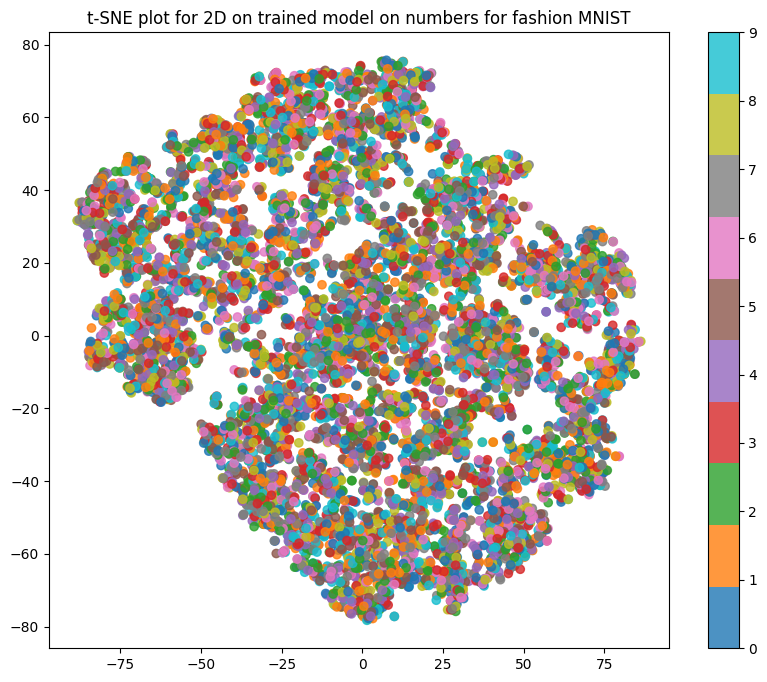

In [54]:
#plotting the 2d tSNE plot
# print(layer_2_output_2d.shape)

#for assignning the colors, we can use the feature of the parameter c, which assigns different colors to the points, according to their values present in the data_y_test

plt.figure(figsize=(10, 8))
plt.scatter(layer_2_output_2d[:, 0], layer_2_output_2d[:, 1], c=data_y_test, cmap='tab10', alpha=0.8)
plt.colorbar()
plt.title('t-SNE plot for 2D on trained model on numbers for fashion MNIST')
plt.show()

3-D plot

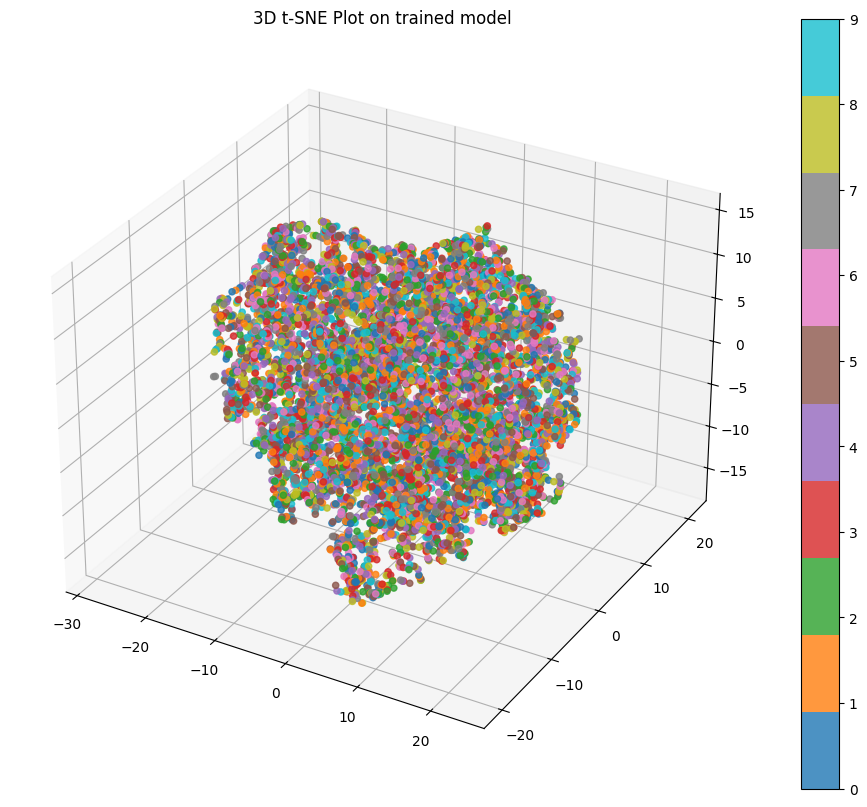

In [55]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotting with 'plasma' colormap for better colors
scatter = ax.scatter(
    layer_2_output_3d[:, 0], 
    layer_2_output_3d[:, 1], 
    layer_2_output_3d[:, 2], 
    c=data_y_test, cmap='tab10', alpha=0.8
)

# Simplified colorbar
colorbar = plt.colorbar(scatter)
plt.title('3D t-SNE Plot on trained model')
plt.show()

Observations

The 2-D plot shows that the model is not able to differentiate between the fashion dataset, and the digits dataset, as the points are placed randomly, and are not clustered.

The 3-D plot also shows the same, as the points are placed randomly, and are not clustered.

Unlike the embedding of the digits dataset, the embedding of the fashion dataset is not able to differentiate between the classes, and the points are placed randomly, and are not clustered.